## 1. Initial setting

Mitsuba 3 does not use external array-based numeric backend such as NumPy or PyTorch, but use its own backend, named Dr. Jit.
You should call `mi.set_variant` method before running any other mitsuba functions.

Mitsuba 3 can load scene information using XML files or Python dictionary variables. To testing Mitsuba 3 API usage, `mi.cornell_box()` function is useful.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import drjit as dr
import mitsuba as mi
mi.set_variant('cuda_ad_rgb', 'llvm_ad_rgb')
# mi.set_variant('scalar_rgb')
print(f"{mi.variant()=}")

mi.variant()='cuda_ad_rgb'


*What is a Mitsuba variant?*

Mitsuba classes such as `mi.Float` and `mi.Spectrum` have high level meaning, but their internal structure become different depending which *Mitsuba variant* the user set at the first of the program.

Additional reading:
* https://mitsuba.readthedocs.io/en/stable/src/key_topics/variants.html

In [2]:
import mitsuba as mi
mi.set_variant('scalar_rgb')
print("========== scalar_rgb ==========")
print(mi.Spectrum(0.0).numpy())

print("========== scalar_spectral ==========")
mi.set_variant('scalar_spectral')
print(mi.Spectrum(0.0).numpy())

print("\n========== scalar_rgb ==========")
mi.set_variant('scalar_rgb')
print(f"{mi.Int = }")
print(f"{mi.Float = }")
print(mi.Point3f(0.0, 0.0, 0.0).numpy().shape) # (3,), the data represents only a single point

print("========== cuda_ad_rgb ==========")
mi.set_variant('cuda_ad_rgb')
# print("========== llvm_ad_rgb ==========")
# mi.set_variant('llvm_ad_rgb')
print(f"{mi.Int = }")
print(f"{mi.Float = }")
print(mi.Point3f(0.0, 0.0, 0.0).numpy().shape) # (1, 3), the data represents vectorized array of points

========== scalar_rgb ==========
[0. 0. 0.]
========== scalar_spectral ==========
[0. 0. 0. 0.]

========== scalar_rgb ==========
mi.Int = <class 'int'>
mi.Float = <class 'float'>
(3,)
========== cuda_ad_rgb ==========
mi.Int = <class 'drjit.cuda.ad.Int'>
mi.Float = <class 'drjit.cuda.ad.Float'>
(3, 1)


In [3]:
import mitsuba as mi
mi.set_variant('cuda_ad_rgb')

scene = mi.load_dict(mi.cornell_box())
print(f"{type(scene) = }")
print(scene)

type(scene) = <class 'mitsuba.Scene'>
Scene[
  children = [
    Rectangle[
      to_world = [[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, -1],
                  [0, 0, 0, 1]],
      frame = Frame[
        s=[[2, 0, 0]],
        t=[[0, 2, 0]],
        n=[[0, 0, 1]]
      ],
      surface_area = [4],
      bsdf = SmoothDiffuse[
        reflectance = SRGBReflectanceSpectrum[
          value = [[0.885809, 0.698859, 0.666422]]
        ]
      ]
    ],
    Rectangle[
      to_world = [[1, 0, 0, 0],
                  [0, -4.37114e-08, -1, 1],
                  [0, 1, -4.37114e-08, 0],
                  [0, 0, 0, 1]],
      frame = Frame[
        s=[[2, 0, 0]],
        t=[[0, -8.74228e-08, 2]],
        n=[[0, -1, -4.37114e-08]]
      ],
      surface_area = [4],
      bsdf = SmoothDiffuse[
        reflectance = SRGBReflectanceSpectrum[
          value = [[0.885809, 0.698859, 0.666422]]
        ]
      ]
    ],
    Rectangle[
      to_world = [[1, 0, 0, 0],
        

-----
## 2. Sampler

**Task 1.** Check independence of subsequent outputs of `sampler.next_1d` through numerical experiment

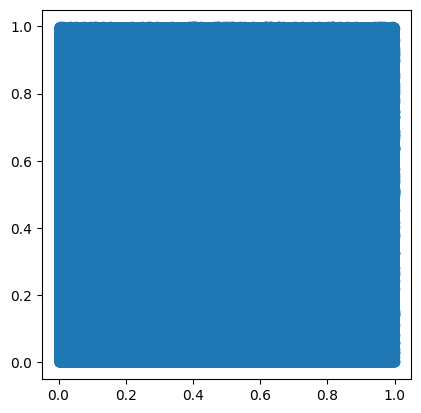

In [4]:
mi.set_variant('scalar_rgb')

N = 1000000
First = np.zeros(N)
Second = np.zeros(N)

sampler = mi.load_dict({'type': 'independent'})
for seed in range(N):
    sampler.seed(seed)
    First[seed] = sampler.next_1d()
    Second[seed] = sampler.next_1d()

# --- Plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(First, Second)
ax.set_aspect('equal')
plt.show()

Consecutivly calling `next_1d` or `next_2d` gives *independent* random samples. Check they are really independent. Showing independence of random variables are too difficult, so we will check a weak version (necessary condition): if $X$ and $Y$ are two independent random variables, then $X^n Y^m$ should have zero covariance.

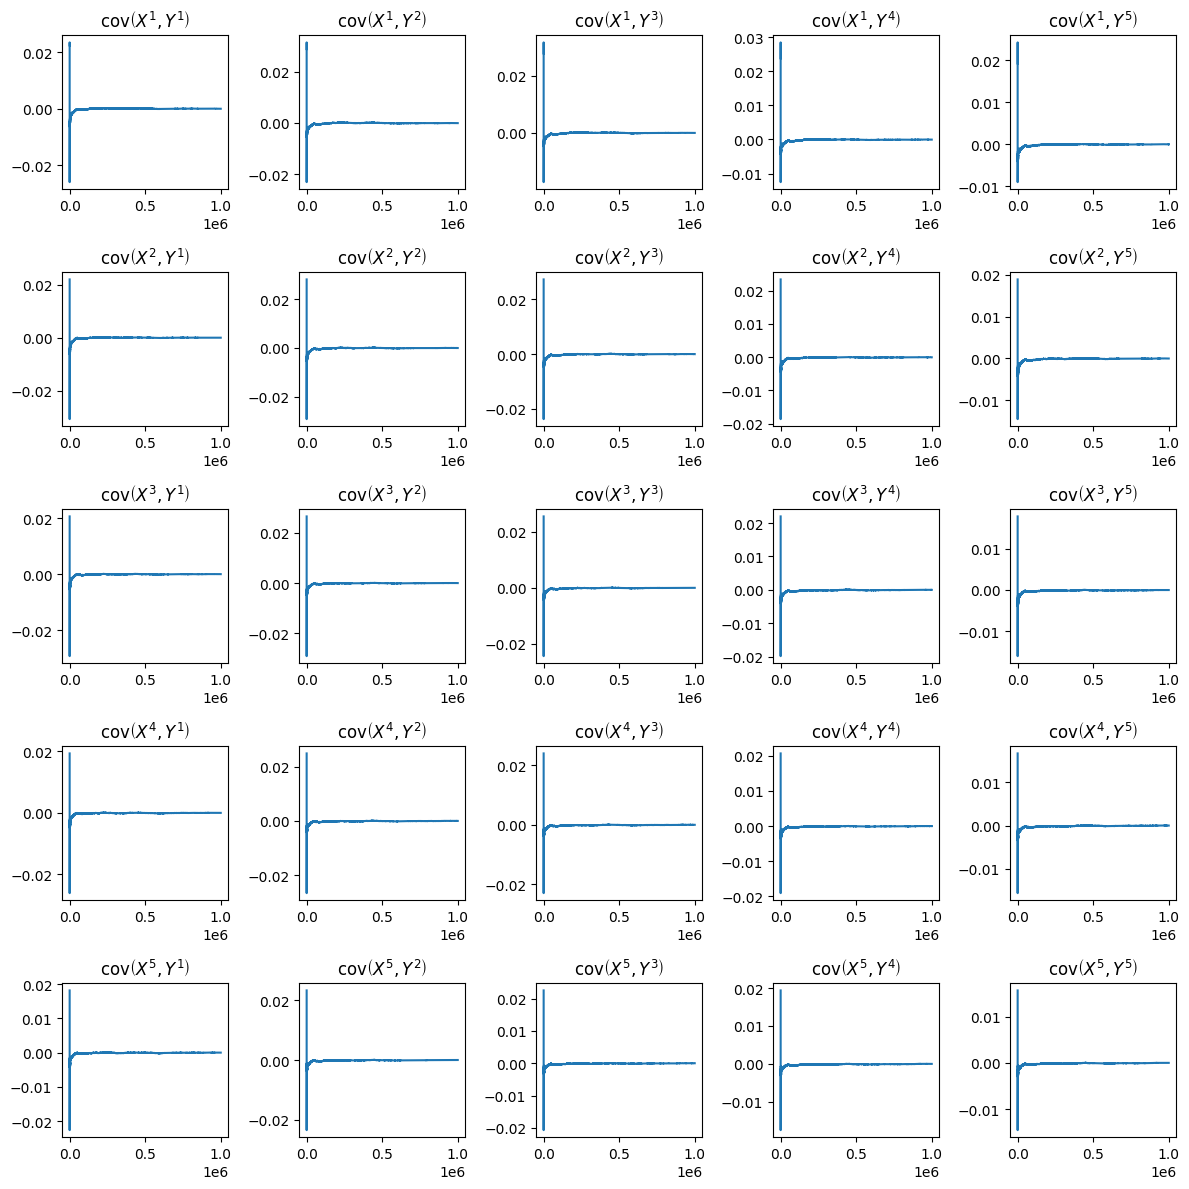

In [5]:
def cummean(a, axis=None):
    a_cumsum = np.cumsum(a, axis=axis)
    if axis is None:
        count = np.arange(1, a.size+1).reshape(a.shape)
    else:
        if axis < 0:
            axis = a.ndim + axis
        count = np.expand_dims(np.arange(1, a.shape[axis]+1), tuple(range(axis-a.ndim+1, 0)))
    return a_cumsum / count

max_power = 5
# Array[power of First, power of Second, sample for each seed]
first_power = np.arange(1, max_power+1)[:, None, None]
second_power = np.arange(1, max_power+1)[None, :, None]

First_powered = First**first_power
Second_powered = Second**second_power
Cov = cummean(First_powered*Second_powered, axis=-1) - cummean(First_powered, axis=-1) * cummean(Second_powered, axis=-1)
Cov = Cov[:,:,1:]

# --- Plot
plot_X = np.arange(1, N)
fig = plt.figure(figsize=(12,12))
for i in range(max_power):
    for j in range(max_power):
        ax = fig.add_subplot(max_power, max_power, i*max_power + j+1)
        ax.plot(plot_X, Cov[i, j, :])
        ax.set_title("$\\mathrm{cov}\\left(X^{%d}, Y^{%d}\\right)$" % (i+1, j+1))
plt.tight_layout()
plt.show()

-----
## 2. Ray intersection and little bit about Dr. Jit 

In [6]:
mi.set_variant('cuda_ad_rgb', 'llvm_ad_rgb')

o = np.array([[0, 0, 0], [1, 1, 1], [0, 0, 0], [0, 0, 1]]).T
d = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0], [1, 0, 0]]).T
ray = mi.Ray3f(o, d)
print(f"{type(ray) = }")
print(f"{dr.shape(ray) = }")
print(f"{dr.width(ray) = }")
print(ray, '\n')

print(f"{type(ray.o) = }")
print(f"{dr.shape(ray.o) = }")
print(f"{np.array(ray.o).shape = }")
print(ray.o)
print(f"{type(ray.d) = }")
print(ray.d)

type(ray) = <class 'mitsuba.Ray3f'>
dr.shape(ray) = ()
dr.width(ray) = 4
Ray[
  o=[[0, 0, 0],
     [1, 1, 1],
     [0, 0, 0],
     [0, 0, 1]],
  d=[[0, 0, 1],
     [0, 1, 0],
     [1, 0, 0],
     [1, 0, 0]],
  maxt=[3.40282e+38],
  time=[0],
  wavelengths=[]
] 

type(ray.o) = <class 'mitsuba.Point3f'>
dr.shape(ray.o) = (3, 4)
np.array(ray.o).shape = (3, 4)
[[0, 0, 0],
 [1, 1, 1],
 [0, 0, 0],
 [0, 0, 1]]
type(ray.d) = <class 'mitsuba.Vector3f'>
[[0, 0, 1],
 [0, 1, 0],
 [1, 0, 0],
 [1, 0, 0]]


In [7]:
o = np.zeros((2,3,4))
d = np.ones((2,3,4))
try:
    ray = mi.Ray3f(o, d)
except:
    print("Error!")

o = np.zeros((2,4,3))
d = np.ones((2,4,3))
try:
    ray = mi.Ray3f(o, d)
except:
    print("Error!")

o = np.zeros((3,2,4))
d = np.ones((3,2,4))
try:
    ray = mi.Ray3f(o, d)
except:
    print("Error!")

Error!
Error!
Error!


In [8]:
p =mi.Point3f(np.zeros((3,2)))
print(f"{type(p) = }")
print(f"{dr.shape(p) = }")
print(p)
print(np.array_equal(p.numpy(), np.array(p)))
print(f"{p.numpy().shape = }")

print(f"{mi.Point3f(np.zeros((3,))).numpy().shape = }")

type(p) = <class 'mitsuba.Point3f'>
dr.shape(p) = (3, 2)
[[0, 0, 0],
 [0, 0, 0]]
True
p.numpy().shape = (3, 2)
mi.Point3f(np.zeros((3,))).numpy().shape = (3, 1)


In [9]:
p = mi.Point3f(np.arange(6).reshape(3,2))
print(f"{dr.width(p)}")
print(f"{p}", '\n')

print(f"{dr.shape(p[0]) = }")
print(f"{p[0] = }", '\n')

print(f"{dr.shape(p.x) = }")
print(f"{p.x = }", '\n')

try:
    print(f"{p[:,0] = }")
except:
    print("Error: p[:,0]")
try:
    print(f"{p[:,0] = }")
except:
    print("Error: p[:,0]")


2
[[0, 2, 4],
 [1, 3, 5]] 

dr.shape(p[0]) = (2,)
p[0] = [0, 1] 

dr.shape(p.x) = (2,)
p.x = [0, 1] 

Error: p[:,0]
Error: p[:,0]


In [10]:
si = scene.ray_intersect(ray)
print(f"{type(si) = }")
print(f"{dr.shape(si) = }")
print(f"{dr.width(si) = }")
print(si)

type(si) = <class 'mitsuba.SurfaceInteraction3f'>
dr.shape(si) = ()
dr.width(si) = 4
SurfaceInteraction[
  t=[inf, 0, 1, 1],
  time=[0],
  wavelengths=[],
  p=[[0, 0, 0],
     [1, 1, 1],
     [1, 0, 0],
     [1, 0, 1]],
  n=[[0, 0, 0],
     [0, -1, -4.37114e-08],
     [-1, 0, -4.37114e-08],
     [-1, 0, -4.37114e-08]],
  shape=[0x0, 0x273b727d180, 0x273b727aab0, 0x273b727aab0],
  uv=[[0, 0],
      [1, 1],
      [0.5, 0.5],
      [1, 0.5]],
  sh_frame=Frame[
             s=[[1, -0, -0],
                [1, 0, 0],
                [-4.37114e-08, 0, 1],
                [-4.37114e-08, 0, 1]],
             t=[[0, 0, -0],
                [0, -4.37114e-08, 1],
                [0, 1, 0],
                [0, 1, 0]],
             n=[[0, 0, 0],
                [0, -1, -4.37114e-08],
                [-1, 0, -4.37114e-08],
                [-1, 0, -4.37114e-08]]
],
  dp_du=[[0, 0, 0],
         [2, 0, 0],
         [-8.74228e-08, 0, 2],
         [-8.74228e-08, 0, 2]],
  dp_dv=[[0, 0, 0],
         [0, -

In [11]:
import mitsuba as mi
mi.set_variant('scalar_rgb')
print(mi.Point3f(1, 2, 3).numpy().shape)

mi.set_variant('cuda_ad_rgb')
print(mi.Point3f(1, 2, 3).numpy().shape)

mi.set_variant('llvm_ad_rgb')
print(mi.Point3f(1, 2, 3).numpy().shape)

(3,)
(3, 1)
(3, 1)


Ray intersect cohenret test

In [12]:
scene = mi.load_dict(mi.cornell_box())
sampler = mi.load_dict({'type': 'independent'})
sensor = scene.sensors()[0]
print(f"{type(scene)=}")
print(f"{type(sampler)=}")
print(f"{type(sensor)=}")

type(scene)=<class 'mitsuba.Scene'>
type(sampler)=<class 'mitsuba.Sampler'>
type(sensor)=<class 'mitsuba.ProjectiveCamera'>


In [13]:
sensor.sample_ray(time=0, sample1=0, sample2=sampler.next_2d(), sample3=0)

(Ray[
   o=[[-0.00027973, -0.000290686, 3.899]],
   d=[[-0.259416, -0.269576, -0.927379]],
   maxt=[107.83],
   time=[0],
   wavelengths=[]
 ],
 [[1, 1, 1]])